## Algoritmos de Búsqueda

A continuación se muestra la implementación de los distintos algoritmos de búsqueda pedidos para este trabajo, a continuación
procederé a explicar cada una de las clases.

### Clase Nodo
Esta clase representa lo que sería un nodo del grafo así como sus atributos principales

In [3081]:
import queue
from collections import deque

from geopy.distance import geodesic


class Nodo:
    # estado: Estado del nodo actual, padre: Nodo padre, accion: Accion del padre a mí

    def __init__(self, estado, padre=None, accion=None):
        self.estado = estado
        self.padre = padre
        self.accion = accion
        self.coste = 0 if padre is None else padre.coste + accion.coste
        self.profundidad = 0 if padre is None else padre.profundidad + 1
        self.fn = 0

    def __eq__(self, otro):  # Para mejor comparación de objetos
        return isinstance(otro, Nodo) and self.estado.identificador == otro.estado.identificador

    def __hash__(self):  # Para localización óptima de objetos en secuencias
        return hash(self.estado.identificador)

    def __lt__(self, other):
        return isinstance(other, Nodo) and self.estado.identificador < other.estado.identificador


### Clase Estado
La clase estado representa los estados en los que se puede encontrar un nodo del grafo, en este trabajo viene representado por 
las intersecciones.

In [3082]:
class Estado:

    def __init__(self, identificador, longitud, latitud):
        self.identificador = identificador
        self.longitud = longitud
        self.latitud = latitud

    def __hash__(self):
        return hash(self.identificador)

    def __eq__(self, otro):
        return isinstance(otro, Estado) and self.identificador == otro.identificador

### Clase Acción
La clase acción representa los movimientos que puede hacer un nodo desde un estado determinado, en este trabajo viene
representado por los segments.

In [3083]:
class Accion:

    def __init__(self, origen, destino, distancia, velocidad):
        self.velocidad = velocidad / 3.6  # ponemos la velocidad en m/s
        self.distancia = distancia
        self.coste = self.distancia / self.velocidad  # coste = distancia / velocidad
        self.origen = origen
        self.destino = destino

    def __hash__(self):
        return hash((self.origen, self.destino))

    def __eq__(self, otro):
        return isinstance(otro, Accion) and self.origen == otro.origen and self.destino == otro.destino


### Clase Problema
La clase problema representa toda la información que vamos a necesitar para trabajar con los respectivos algoritmos y
poder implementarlos correctamente.

In [3084]:
from collections import defaultdict


class Problema:

    def __init__(self, data):
        self.acciones = defaultdict(list)  # Viene representado por los segments en los datos del problema
        self.estados = defaultdict(list)  # Viene representado por las intersecciones del problema
        self.estado_inicial = None
        self.estado_final = None
        self.vel_maxima = 0
        self.procesar_datos(data)
        self.estado_inicial = self.estados[data.get('initial')]
        self.estado_final = self.estados[data.get('final')]

    def procesar_datos(self, data):

        for interseccion in data.get('intersections', []):  # Procesamos las intersecciones 
            identificador = interseccion.get('identifier')
            if identificador not in self.estados.keys():
                estado = Estado(
                    identificador,
                    interseccion.get('longitude'),
                    interseccion.get('latitude')
                )
                self.estados[identificador] = estado

        for segmento in data.get('segments', []):  # Transformamos los segments en acciones para cada estado
            origen = segmento.get('origin')
            destino = segmento.get('destination')
            distancia = segmento.get('distance')
            velocidad = segmento.get('speed')

            if velocidad <= 0:
                continue

            if origen in self.estados and destino in self.estados:
                accion = Accion(origen, destino, distancia, velocidad)
                self.vel_maxima = max(accion.velocidad, self.vel_maxima)  # obtenemos la velocidad máxima del problema
                self.acciones[origen].append(accion)

        for origen in self.acciones:
            self.acciones[origen].sort(key=lambda x: x.origen)

### Clase Búsqueda
En esta clase se implementa la lógica básica que van a compartir todos los algoritmos de búsqueda que vamos a implementar
así como la información y estructura común entre ellas.


In [3085]:
from abc import ABC, abstractmethod


class Busqueda(ABC):

    def __init__(self, problema):
        self.nodos_generados = 0
        self.nodos_expandidos = 0
        self.coste = 0
        self.tamanyo_solucion = 0
        self.problema = problema
        self.cerrados = set()
        self.frontera = None

    def generar_solucion(self, nodo):  #obtenemos el camino a la solución
        nodo_actual = nodo
        camino = [nodo]

        while nodo_actual.profundidad > 0:
            nodo_actual = nodo_actual.padre
            camino.append(nodo_actual)

        self.tamanyo_solucion = len(camino) - 1
        self.coste = nodo.coste
        return camino[::-1]

    def expandir_nodo(self, nodo):

        self.nodos_expandidos += 1
        sucesores = []
        acciones = self.problema.acciones.get(nodo.estado.identificador, [])

        for accion in acciones:
            nodo_sucesor = Nodo(self.problema.estados[accion.destino], nodo, accion)
            sucesores.append(nodo_sucesor)
            self.nodos_generados += 1
            if nodo_sucesor.estado == self.problema.estado_final:
                return sucesores
        return sucesores

    
    def buscar(self):

        while self.frontera:
            nodo_actual = self.extraer(self.frontera)
            if self.problema.estado_final.identificador == nodo_actual.estado.identificador:
                return self.generar_solucion(nodo_actual)
            if nodo_actual.estado not in self.cerrados:
                self.cerrados.add(nodo_actual.estado)
                sucesores = self.expandir_nodo(nodo_actual)
                self.insertar(sucesores, self.frontera)
        return []

    @abstractmethod
    def init_frontera(self, estado_inicial):
        pass

    @abstractmethod
    def insertar(self, nodos, frontera):
        pass

    @abstractmethod
    def extraer(self, frontera):
        pass


### Clase BusquedaNoInformada

In [3086]:
class BusquedaNoInformada(Busqueda):

    def __init__(self, problema):
        super().__init__(problema)

    
    def buscar(self):
        return super().buscar()

    @abstractmethod
    def init_frontera(self, estado_inicial):
        pass

    @abstractmethod
    def insertar(self, nodos, frontera):
        pass

    @abstractmethod
    def extraer(self, frontera):
        pass

### Clase BFS
Esta clase representa la implementación del algoritmo de búsqueda primero en anchura

In [3087]:
class BFS(BusquedaNoInformada):

    def __init__(self, problema):
        super().__init__(problema)
        self.frontera = self.init_frontera(problema.estado_inicial)

    def buscar(self):
        return super().buscar()

    def extraer(self, frontera):
        return frontera.popleft()

    def init_frontera(self, estado_inicial):
        return deque([Nodo(estado_inicial)])

    def insertar(self, nodos, frontera):
        nodos.sort(key=lambda x: x.estado.identificador)
        for a in nodos:
            frontera.append(a)

### Clase DFS
Esta clase representa la implementación del algoritmo de búsqueda primero en profundidad.


In [3088]:
class DFS(BusquedaNoInformada):

    def __init__(self, problema):
        super().__init__(problema)
        self.frontera = self.init_frontera(problema.estado_inicial)

    def buscar(self):
        return super().buscar()

    def extraer(self, frontera):
        return frontera.pop()

    def init_frontera(self, estado_inicial):
        return deque([Nodo(estado_inicial)])

    def insertar(self, nodos, frontera):
        nodos.sort(key=lambda x: x.estado.identificador)
        for a in nodos:
            frontera.append(a)

### Clase LDFS
Esta clase representa la implementación del algoritmo de búsqueda primero en profundidad limitada.

In [ ]:
class LDFS(DFS):

    def __init__(self, problema, limite_profundidad = 10):
        super().__init__(problema)
        self.limite_profundidad = limite_profundidad

    def extraer(self, frontera):
        return super().extraer(frontera)

    def init_frontera(self, estado_inicial):
        return super().init_frontera(estado_inicial)

    def insertar(self, nodos, frontera):
        super().insertar(nodos, frontera)

    def buscar(self):
        
        # Reinicializar, sobre toodo cuando se ejecuta varias veces, IDFS
        self.frontera = self.init_frontera(self.problema.estado_inicial)
        self.cerrados = set()
        
        while self.frontera:
            nodo_actual = self.extraer(self.frontera)
            if self.problema.estado_final.identificador == nodo_actual.estado.identificador:
                return self.generar_solucion(nodo_actual)
            if nodo_actual.estado not in self.cerrados and nodo_actual.profundidad <= self.limite_profundidad:
                self.cerrados.add(nodo_actual.estado)
                sucesores = self.expandir_nodo(nodo_actual)
                self.insertar(sucesores, self.frontera)
        return []



### Clase IDFS
Esta clase representa la implementación del algoritmo de búsqueda primero en profundidad iterativa.

In [3090]:
class IDFS(DFS):

    def __init__(self, problema):
        super().__init__(problema)
        self.frontera = self.init_frontera(problema.estado_inicial)
        self.profundidad_maxima = len(self.problema.estados)

    def extraer(self, frontera):
        return super().extraer(frontera)

    def init_frontera(self, estado_inicial):
        return super().init_frontera(estado_inicial)

    def insertar(self, nodos, frontera):
        super().insertar(nodos, frontera)

    def buscar(self):
        
        solucion = []
        for profundidad in range(self.profundidad_maxima):
            algoritmo = LDFS(self.problema, profundidad)
            
            # Reiniciamos las estadísticas del algoritmo
            algoritmo.nodos_generados = 0
            algoritmo.nodos_expandidos = 0
            algoritmo.coste = 0
            algoritmo.tamanyo_solucion = 0
            algoritmo.cerrados = set()
            
            # buscamos la solución con el algoritmo LDFS
            solucion = algoritmo.buscar()
            if len(solucion) > 0:
                self.nodos_generados = algoritmo.nodos_generados
                self.nodos_expandidos = algoritmo.nodos_expandidos
                self.coste = algoritmo.coste
                self.tamanyo_solucion = algoritmo.tamanyo_solucion
                return solucion
            
        return solucion



### Clase BusquedaInformada
Esta clase representa la lógica común entre los algoritmos de búsqueda informada.

In [3091]:
class BusquedaInformada(Busqueda):

    def __init__(self, problema):
        super().__init__(problema)
        

    def buscar(self):
        self.nodos_generados = + 1
        return super().buscar()

    @abstractmethod
    def init_frontera(self, estado_inicial):
        pass

    @abstractmethod
    def insertar(self, nodos, frontera):
        pass

    @abstractmethod
    def extraer(self, frontera):
        pass

    @abstractmethod
    def calcular_heuristica(self, candidatos, objetivo, vel_maxima):
        pass



### Clase BF
Esta clase representa la implementación del algoritmo de búsqueda primero mejor, en el que la heurística empleada
es la distancia geodésica.

In [3092]:
class BF(BusquedaInformada):

    def __init__(self, problema):
        super().__init__(problema)
        self.frontera = self.init_frontera(problema.estado_inicial)

    # inicializamos la frontera como una cola de prioridad para ordenar según la heurística utilizada
    def init_frontera(self, estado_inicial):
        cola_prioridad = queue.PriorityQueue()
        cola_prioridad.put((0, Nodo(estado_inicial)))
        return cola_prioridad

    def insertar(self, nodos, frontera):
        self.calcular_heuristica(nodos, self.problema.estado_final, self.problema.vel_maxima)
        for nodo in nodos:
            frontera.put((nodo.fn, nodo))

    def extraer(self, frontera):
        return frontera.get()[1]

    def buscar(self):
        return super().buscar()

    def calcular_heuristica(self, candidatos, objetivo, vel_maxima):
        destino = (objetivo.latitud, objetivo.longitud)
        for nodo in candidatos:
            coord2 = (nodo.estado.latitud, nodo.estado.longitud)
            nodo.fn = (geodesic(destino, coord2).m / vel_maxima)


### Clase AStar
Esta clase representa la implementación del algoritmo de búsqueda A estrella

In [3093]:
class AStar(BusquedaInformada):

    def __init__(self, problema):
        super().__init__(problema)
        self.frontera = self.init_frontera(problema.estado_inicial)

    def init_frontera(self, estado_inicial):
        cola_prioridad = queue.PriorityQueue()
        nodo_inicial = Nodo(estado_inicial)
        cola_prioridad.put((0, nodo_inicial))
        return cola_prioridad

    def insertar(self, nodos, frontera):
        self.calcular_heuristica(nodos, self.problema.estado_final, self.problema.vel_maxima)
        for nodo in nodos:
            frontera.put((nodo.fn, nodo))

    def extraer(self, frontera):
        return frontera.get()[1]

    def buscar(self):
        return super().buscar()

    # En este metodo calculamos la distancia geodésica entre cada nodo sucesor y el nodo objetivo
    def calcular_heuristica(self, candidatos, objetivo, velocidad_maxima):
        destino = (objetivo.latitud, objetivo.longitud)
        for nodo in candidatos:
            coord2 = (nodo.estado.latitud, nodo.estado.longitud)
            nodo.fn = nodo.coste + (geodesic(destino, coord2).m / velocidad_maxima)

### Ejecución de los Algoritmos

Para ejecutar este código, sólo es necesario cambiar la ruta del fichero json a una ruta relativa, para ello facilitaré uno
de los ejemplo con la solución.

In [3094]:
import json
import time
import random


def conversor_tiempo(metrica):
    horas = int(metrica // 3600)
    minutos = int((metrica % 3600) // 60)
    segundos = metrica % 60
    return horas, minutos, segundos


""" Procesamos el JSON"""
ruta_json = 'PR1/examples_with_solutions/problems/huge/calle_agustina_aroca_albacete_5000_0.json'
with open(ruta_json, 'r') as file:
    datos = json.load(file)
problema = Problema(datos)
random.seed(3)  # Para reproducibilidad de resultados

opcion = 3

if opcion == 1:
    algoritmo = BFS(problema)
elif opcion == 2:
    algoritmo = DFS(problema)
elif opcion == 3:
    algoritmo = LDFS(problema, limite_profundidad=80)
elif opcion == 4:
    algoritmo = IDFS(problema)
elif opcion == 5:
    algoritmo = BF(problema)
elif opcion == 6:
    algoritmo = AStar(problema)

start_time = time.time()
solucion = algoritmo.buscar()  #Ejecutamos la búsqueda
end_time = time.time()
exec_time = end_time - start_time

# Convertir a horas, minutos y segundos
tiempo = conversor_tiempo(algoritmo.coste)

print(f"Nodos generados: {algoritmo.nodos_generados}")
print(f"Nodos expandidos: {algoritmo.nodos_expandidos}")
print(f"Coste solución: {tiempo[0]}:{tiempo[1]}:{tiempo[2]:.4f}")
print(f"Longitud de la solución: {algoritmo.tamanyo_solucion}")

if len(solucion) > 0:
    print("[", end="")
    for n in solucion:
        if n.accion is not None:
            print(f"{n.accion.origen} → {n.accion.destino} ({n.accion.coste:.4f}),", end="")
    print("]")
else:
    print("No se ha encontrado solución")
tiempo = conversor_tiempo(exec_time)
print(f"Execution time: {tiempo[0]}:{tiempo[1]}:{tiempo[2]:.4f}")

Nodos generados: 698
Nodos expandidos: 345
Coste solución: 0:15:59.3467
Longitud de la solución: 80
[1540051673 → 1990894635 (8.3498),1990894635 → 1530764262 (12.9130),1530764262 → 1526257441 (5.9064),1526257441 → 1526257448 (18.4156),1526257448 → 1526257452 (6.9322),1526257452 → 1540051678 (12.9947),1540051678 → 1540051670 (8.1600),1540051670 → 1540051661 (9.9382),1540051661 → 1526221501 (14.7575),1526221501 → 1526221429 (13.1766),1526221429 → 1526221438 (6.6596),1526221438 → 1396800476 (9.5934),1396800476 → 1396800400 (19.9502),1396800400 → 1526658921 (19.8845),1526658921 → 1526658962 (18.6740),1526658962 → 1526221485 (8.0375),1526221485 → 1674847662 (11.9624),1674847662 → 1526221497 (7.2632),1526221497 → 1526221449 (7.4186),1526221449 → 1526221507 (9.9013),1526221507 → 2383148353 (6.5974),2383148353 → 1526221498 (8.2157),1526221498 → 1529623334 (18.9826),1529623334 → 1530763847 (5.3656),1530763847 → 1530764289 (15.0092),1530764289 → 1529623297 (15.5779),1529623297 → 1566996115 (11.2

## Generación de Gráficos
__AVISO: El código que se muestra a continuación no es mío, sólo lo he utilizado para
mostrar los gráficos a partir de las tablas calculadas.__

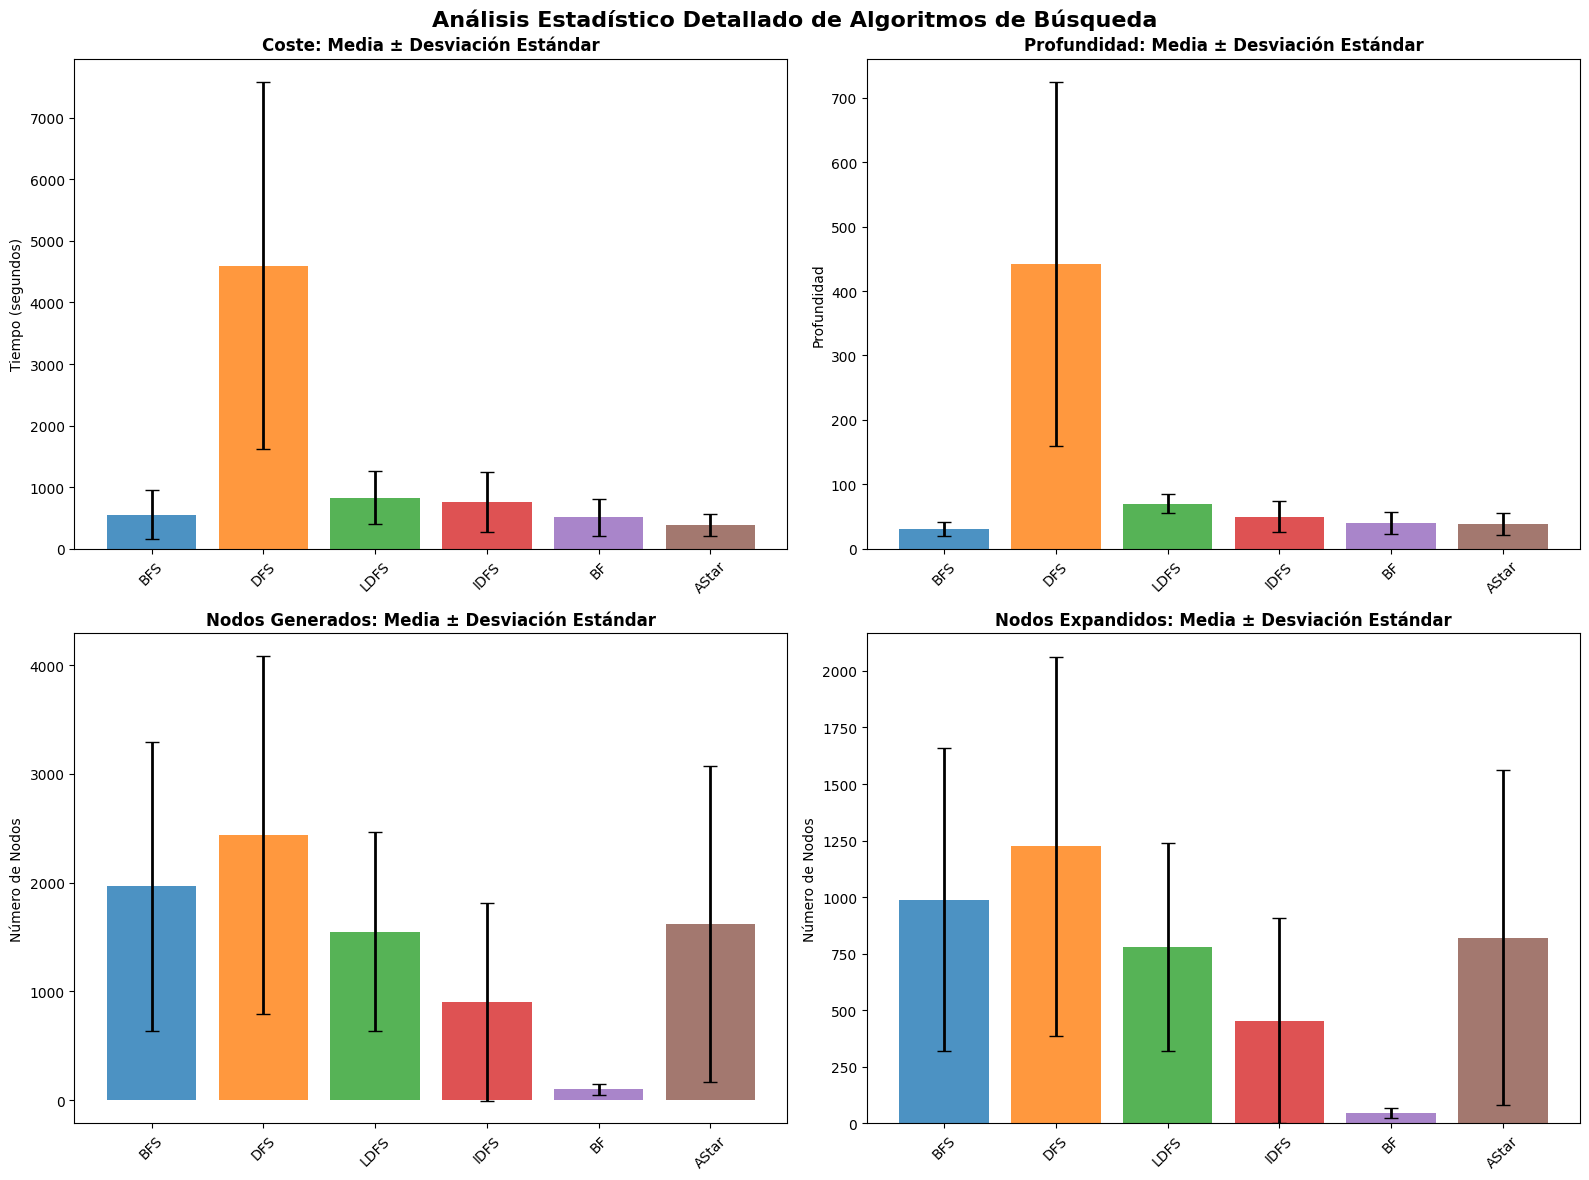

In [3]:
# Análisis estadístico detallado y correlaciones
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Datos de los algoritmos basados en los resultados obtenidos
algoritmos = ['BFS', 'DFS', 'LDFS', 'IDFS', 'BF', 'AStar']

# Datos promedio de las métricas (basados en los resultados del análisis)
coste_promedio = [557.92, 4595.62, 833.14, 759.65, 510.36, 386.98]
profundidad_promedio = [30.43, 441.47, 70.43, 50.03, 40.77, 38.83]
generados_promedio = [1964.83, 2439.13, 1549.67, 899.97, 98.47, 1618.33]
expandidos_promedio = [989.43, 1224.13, 778.43, 454.57, 46.83, 820.97]

# Colores para cada algoritmo
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Crear DataFrame más completo con desviaciones estándar
df_completo = pd.DataFrame({
    'Algoritmo': algoritmos,
    'Coste_Media': coste_promedio,
    'Coste_Std': [395.63, 2978.57, 436.35, 484.12, 293.74, 173.17],  # Desviaciones estándar
    'Profundidad_Media': profundidad_promedio,
    'Profundidad_Std': [11.00, 282.40, 14.51, 24.50, 17.04, 17.09],
    'Generados_Media': generados_promedio,
    'Generados_Std': [1328.35, 1649.13, 913.68, 909.32, 51.19, 1450.78],
    'Expandidos_Media': expandidos_promedio,
    'Expandidos_Std': [668.09, 838.69, 459.18, 453.73, 23.14, 739.27]
})

# Crear gráfico de barras con barras de error
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Estadístico Detallado de Algoritmos de Búsqueda', fontsize=16, fontweight='bold')

# Gráfico 1: Coste con barras de error
ax1.bar(algoritmos, df_completo['Coste_Media'], yerr=df_completo['Coste_Std'], 
        color=colores, alpha=0.8, capsize=5, error_kw={'linewidth': 2, 'ecolor': 'black'})
ax1.set_title('Coste: Media ± Desviación Estándar', fontweight='bold')
ax1.set_ylabel('Tiempo (segundos)')
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Profundidad con barras de error
ax2.bar(algoritmos, df_completo['Profundidad_Media'], yerr=df_completo['Profundidad_Std'],
        color=colores, alpha=0.8, capsize=5, error_kw={'linewidth': 2, 'ecolor': 'black'})
ax2.set_title('Profundidad: Media ± Desviación Estándar', fontweight='bold')
ax2.set_ylabel('Profundidad')
ax2.tick_params(axis='x', rotation=45)

# Gráfico 3: Nodos generados con barras de error
ax3.bar(algoritmos, df_completo['Generados_Media'], yerr=df_completo['Generados_Std'],
        color=colores, alpha=0.8, capsize=5, error_kw={'linewidth': 2, 'ecolor': 'black'})
ax3.set_title('Nodos Generados: Media ± Desviación Estándar', fontweight='bold')
ax3.set_ylabel('Número de Nodos')
ax3.tick_params(axis='x', rotation=45)

# Gráfico 4: Nodos expandidos con barras de error
ax4.bar(algoritmos, df_completo['Expandidos_Media'], yerr=df_completo['Expandidos_Std'],
        color=colores, alpha=0.8, capsize=5, error_kw={'linewidth': 2, 'ecolor': 'black'})
ax4.set_title('Nodos Expandidos: Media ± Desviación Estándar', fontweight='bold')
ax4.set_ylabel('Número de Nodos')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

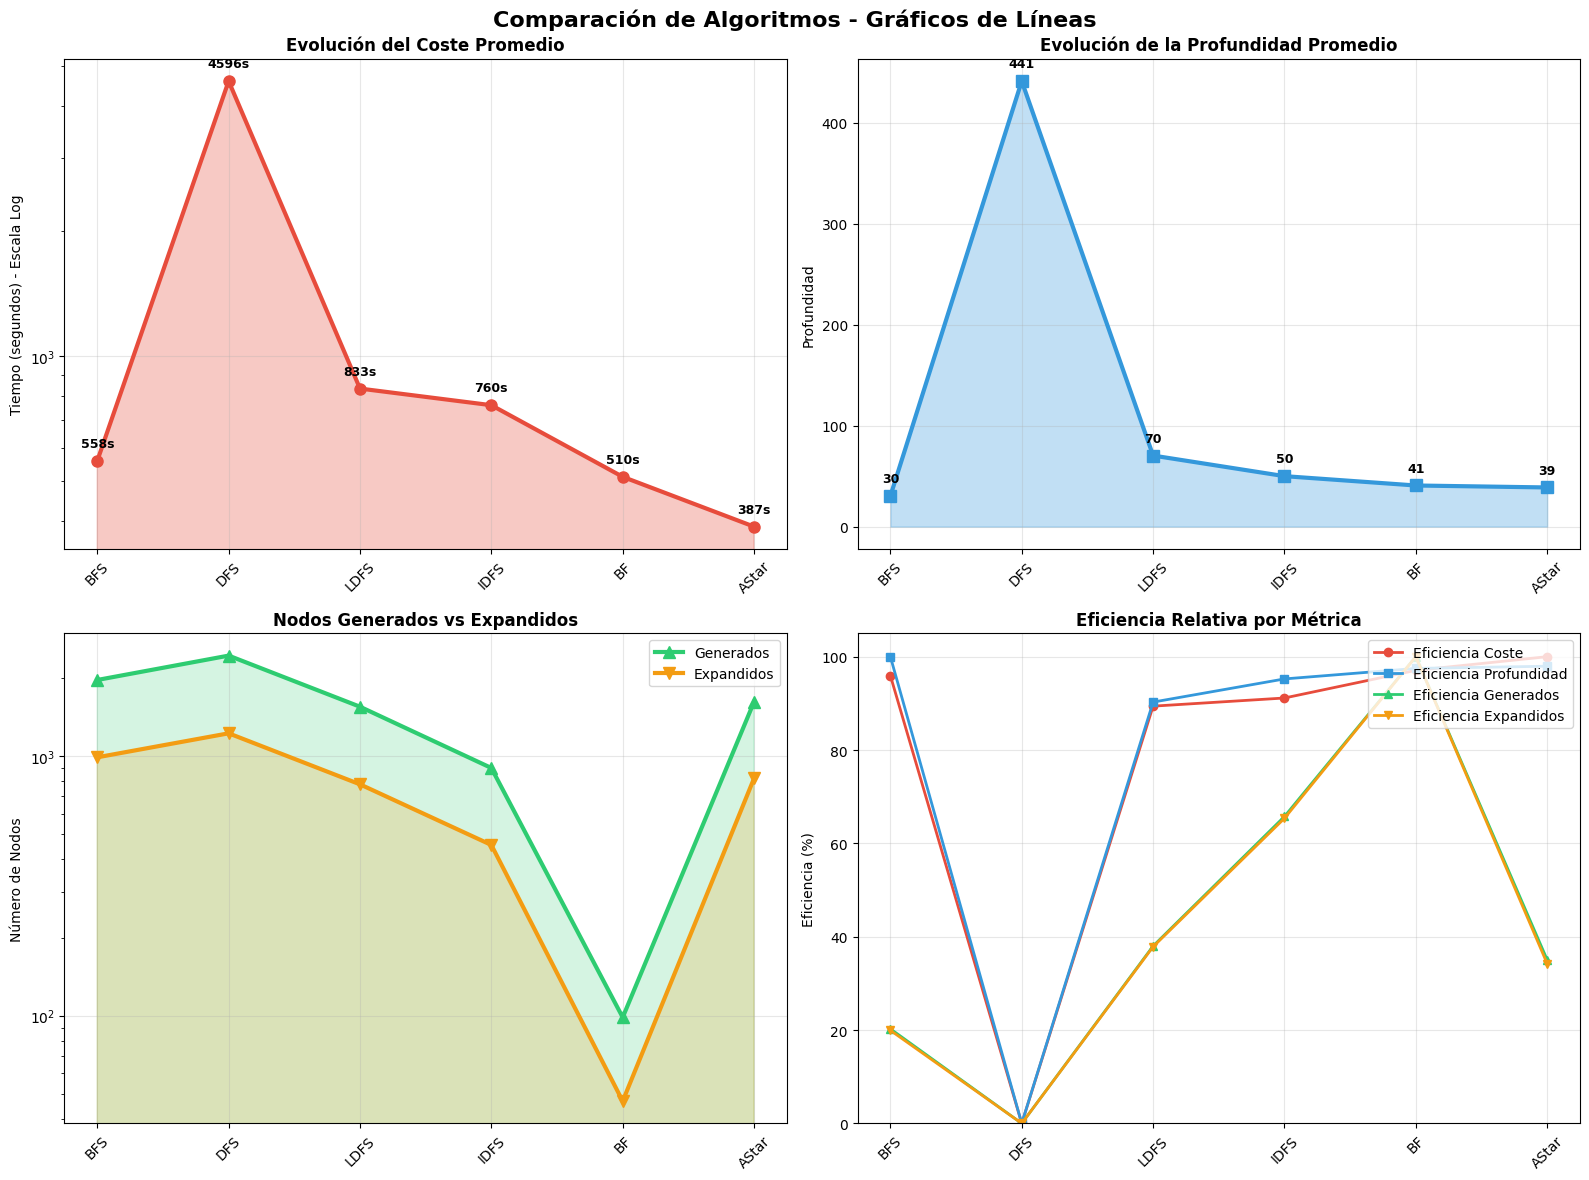

In [4]:
# Gráficos de líneas para comparación de tendencias
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Algoritmos - Gráficos de Líneas', fontsize=16, fontweight='bold')

# Preparar datos para los gráficos de líneas
x_pos = np.arange(len(algoritmos))

# Gráfico 1: Coste (escala logarítmica para mejor visualización)
ax1.plot(x_pos, coste_promedio, 'o-', linewidth=3, markersize=8, color='#e74c3c', label='Coste')
ax1.fill_between(x_pos, coste_promedio, alpha=0.3, color='#e74c3c')
ax1.set_yscale('log')
ax1.set_title('Evolución del Coste Promedio', fontweight='bold')
ax1.set_ylabel('Tiempo (segundos) - Escala Log')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(algoritmos, rotation=45)
ax1.grid(True, alpha=0.3)
# Agregar valores en los puntos
for i, valor in enumerate(coste_promedio):
    ax1.annotate(f'{valor:.0f}s', (i, valor), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# Gráfico 2: Profundidad
ax2.plot(x_pos, profundidad_promedio, 's-', linewidth=3, markersize=8, color='#3498db', label='Profundidad')
ax2.fill_between(x_pos, profundidad_promedio, alpha=0.3, color='#3498db')
ax2.set_title('Evolución de la Profundidad Promedio', fontweight='bold')
ax2.set_ylabel('Profundidad')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(algoritmos, rotation=45)
ax2.grid(True, alpha=0.3)
# Agregar valores en los puntos
for i, valor in enumerate(profundidad_promedio):
    ax2.annotate(f'{valor:.0f}', (i, valor), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# Gráfico 3: Nodos generados y expandidos (escala logarítmica)
ax3.plot(x_pos, generados_promedio, '^-', linewidth=3, markersize=8, color='#2ecc71', label='Generados')
ax3.plot(x_pos, expandidos_promedio, 'v-', linewidth=3, markersize=8, color='#f39c12', label='Expandidos')
ax3.fill_between(x_pos, generados_promedio, alpha=0.2, color='#2ecc71')
ax3.fill_between(x_pos, expandidos_promedio, alpha=0.2, color='#f39c12')
ax3.set_yscale('log')
ax3.set_title('Nodos Generados vs Expandidos', fontweight='bold')
ax3.set_ylabel('Número de Nodos')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(algoritmos, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Eficiencia relativa (todas las métricas normalizadas)
# Normalizar todas las métricas a escala 0-100 (invertir coste y profundidad para que mayor sea mejor)
coste_norm_100 = [(1 - (x - min(coste_promedio)) / (max(coste_promedio) - min(coste_promedio))) * 100 for x in coste_promedio]
prof_norm_100 = [(1 - (x - min(profundidad_promedio)) / (max(profundidad_promedio) - min(profundidad_promedio))) * 100 for x in profundidad_promedio]
gen_norm_100 = [(1 - (x - min(generados_promedio)) / (max(generados_promedio) - min(generados_promedio))) * 100 for x in generados_promedio]
exp_norm_100 = [(1 - (x - min(expandidos_promedio)) / (max(expandidos_promedio) - min(expandidos_promedio))) * 100 for x in expandidos_promedio]

ax4.plot(x_pos, coste_norm_100, 'o-', linewidth=2, markersize=6, label='Eficiencia Coste', color='#e74c3c')
ax4.plot(x_pos, prof_norm_100, 's-', linewidth=2, markersize=6, label='Eficiencia Profundidad', color='#3498db')
ax4.plot(x_pos, gen_norm_100, '^-', linewidth=2, markersize=6, label='Eficiencia Generados', color='#2ecc71')
ax4.plot(x_pos, exp_norm_100, 'v-', linewidth=2, markersize=6, label='Eficiencia Expandidos', color='#f39c12')

ax4.set_title('Eficiencia Relativa por Métrica', fontweight='bold')
ax4.set_ylabel('Eficiencia (%)')
ax4.set_ylim(0, 105)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(algoritmos, rotation=45)
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()